In [6]:
!pip install -Uqq fastai 'duckduckgo_search >= 6.2'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 26.4 MB/s eta 0:00:00


In [7]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [11]:
#importing required libraries

from duckduckgo_search import DDGS
from fastcore.all import *
from fastbook import *
from fastai.vision.all import *
import json, time
from fastdownload import download_url

In [12]:
#Defining an Image Search Function

def search_images_ddg(keyword, max_images=200):
  return L(DDGS().images(keyword, max_results=max_images)).itemgot('image')

In [15]:
#Getting URL for a sample image

url = search_images_ddg('grizzly Bear', 1)
url[0]

'https://d3d0lqu00lnqvz.cloudfront.net/media/media/897b2e5d-6d4c-40fa-bbe8-6829455747e2.jpg'

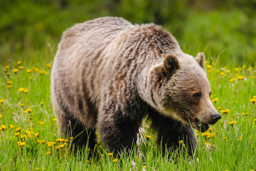

In [17]:
#Displaying the sample image

dest = 'Bear101'
download_url(url[0], dest = dest, show_progress= False)
img = Image.open(dest)
img.to_thumb(256,256)

In [21]:
#Downloading 200 images each for Grizzly Bear, Black Bear and Teddy Bear

bear_types = 'Grizly', 'Black', 'Teddy'
path = Path('Bears')


for i in bear_types:
  dest = (path/i)
  dest.mkdir(exist_ok=True, parents=True)
  download_images(dest, urls=search_images_ddg(f"{i} bear"))



In [30]:
#All the downloaded images are here

fns = get_image_files(path)
len(fns)

562

In [29]:
#Count the Images that are corrupt or failed to Load

failed_images = verify_images(fns)
len(failed_images)

53

In [31]:
#Remove the failed images

failed_images.map(Path.unlink)

(#53) [None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None...]

In [34]:
#Get a DataLoader

bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items = get_image_files,
    get_y = parent_label,
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(128)
)

dls = bears.dataloaders(path)

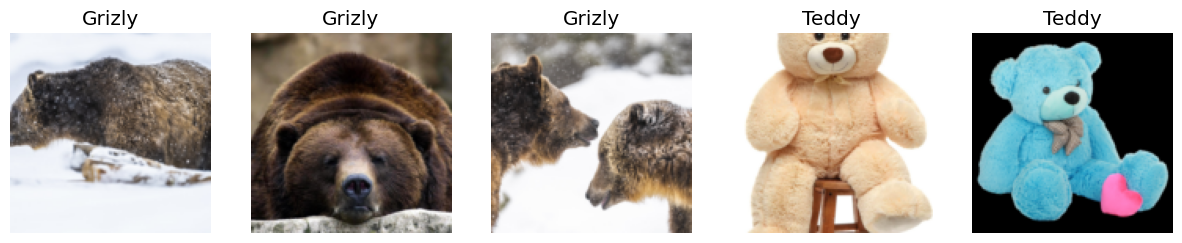

In [37]:
#Showing samples from the dataloaders

dls.valid.show_batch(max_n=5, nrows = 1)

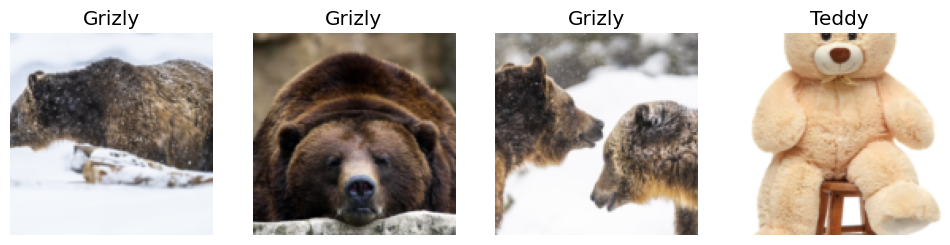

In [40]:
#Resizing the Images using Squish

bears = bears.new(item_tfms= Resize(128, method="Squish"))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n = 4, nrows = 1)

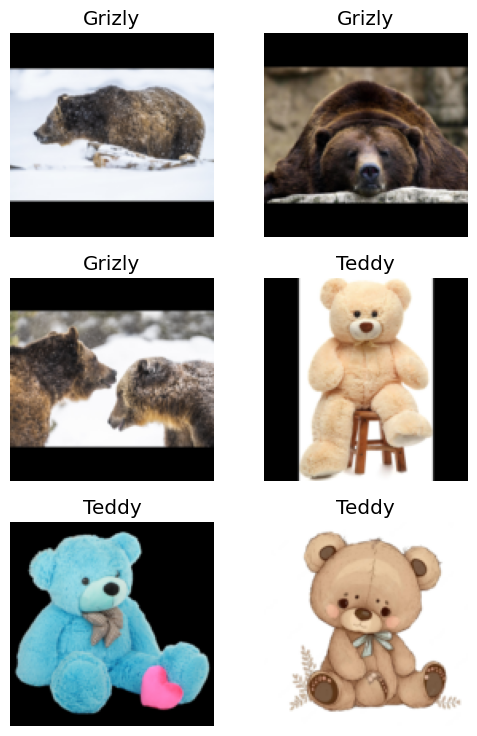

In [43]:
#Resizing images using padding

bears = bears.new(item_tfms= Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=6, nrows = 3)

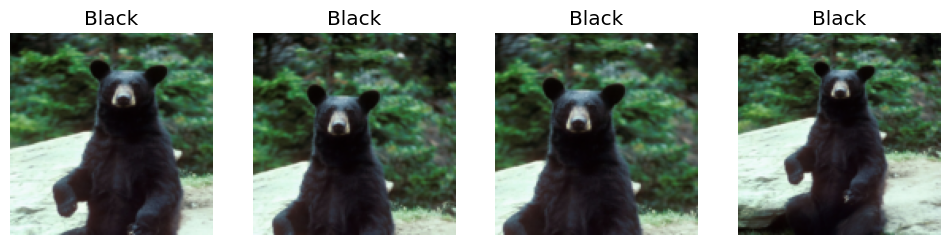

In [50]:
#Transforming the images with RandomResizing that helps the model identify better

bears = bears.new(item_tfms = RandomResizedCrop(128, min_scale = 0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows = 1, unique = True)

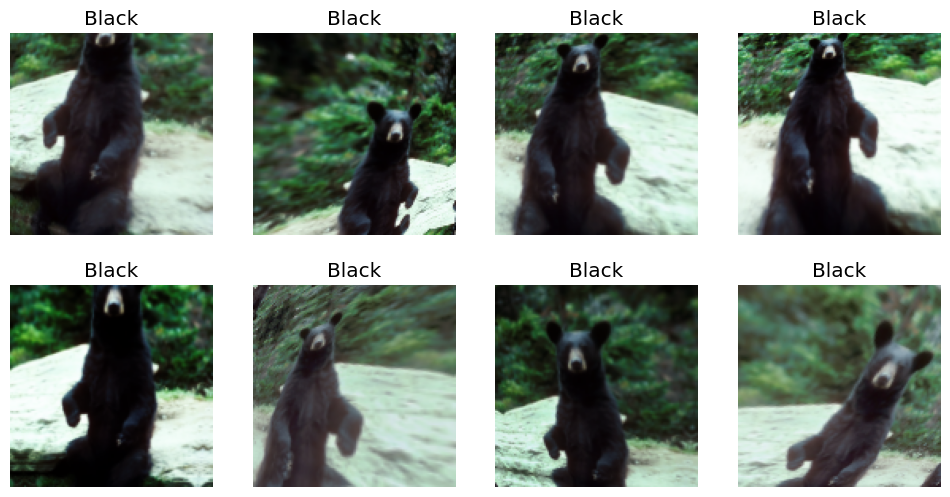

In [51]:
#Augmenting the images

bears = bears.new(item_tfms=Resize(128), batch_tfms = aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows = 2, unique = True)

In [52]:
#Final transformation before training

bears = bears.new(
                  item_tfms= RandomResizedCrop(224, min_scale=0.5),
                  batch_tfms=aug_transforms(mult=2)
                  )
dls = bears.dataloaders(path)


In [53]:
#train a model

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 70.4MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.162968,0.173398,0.039604,01:57


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.253609,0.091118,0.039604,02:22
1,0.207146,0.042451,0.009901,02:19
2,0.186483,0.053475,0.029703,02:19
3,0.182033,0.053655,0.029703,02:19


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


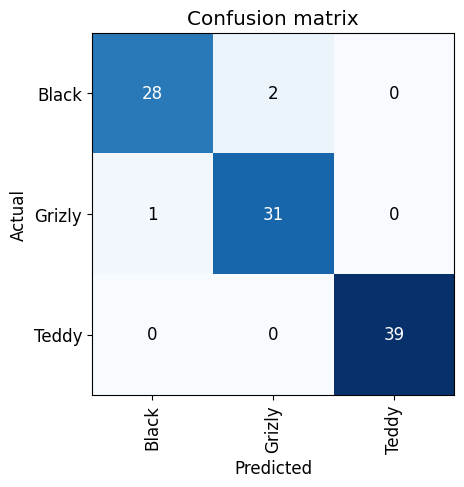

In [55]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

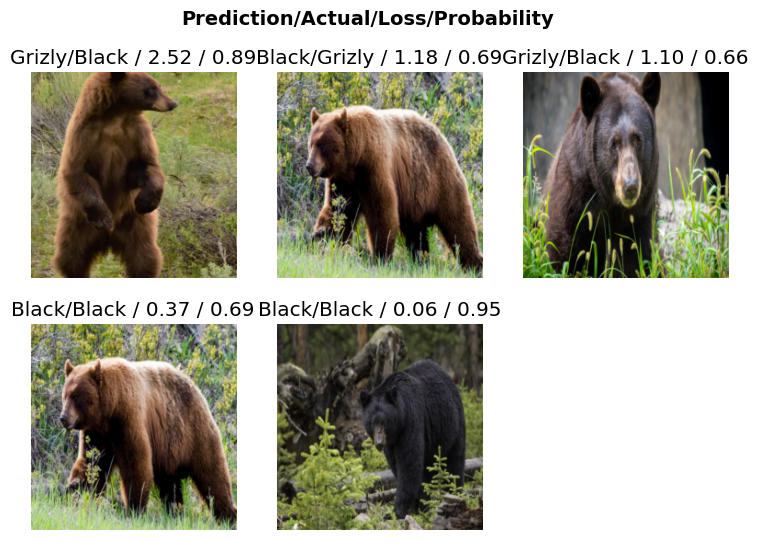

In [58]:
interp.plot_top_losses(k=5)